In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy
from scipy.sparse import linalg, csc_matrix

import matplotlib.pyplot as plt
font = {'size'   : 16}
plt.rc('font', **font)

In [2]:
# Stehfest's inversion method

def Vfunction(i, N):
    sum1 = 0.
    kmin = int(math.floor((i + 1.) / 2.))
    kmax = min(i, N)
    
    for k in range(kmin, kmax+1):
        sum1 += (1.*(k**N) * math.factorial(2 * k) / (math.factorial(N - k) * math.factorial(k) * math.factorial(k - 1) * math.factorial(i - k) * math.factorial(2 * k - i)))
    
    return ((-1.)**(N + i)) * sum1

In [3]:
def rigidity_2D_simple(s, # Laplace variable
             x, # x coordinate of the cell centers
             y, # y coordinate of the cell centers
             nx, # number of cell in each row
             ny, # number of cell in each column
             cxx, # diffusivity xx
             cyy): # diffusivity yy
    
    nCell = nx*ny
    M = np.zeros((nCell,nCell))

    for i in range(1,nx-1):
        for j in range(1,ny-1):
            iCell = i*ny + j

            iW = (i-1)*ny + j
            iE = (i+1)*ny + j
            iS = iCell - 1
            iN = iCell + 1
            iSW = iW - 1
            iNW = iW + 1
            iNE = iE + 1
            iSE = iE - 1

            lx1 = (  (x[i][j+1]-x[i][j-1])/2. + (x[i-1][j+1]-x[i-1][j-1])/2.   ) /2.
            ly1 = (  (y[i][j+1]-y[i][j-1])/2. + (y[i-1][j+1]-y[i-1][j-1])/2.   ) /2.

            lx3 = -(  (x[i][j+1]-x[i][j-1])/2. + (x[i+1][j+1]-x[i+1][j-1])/2.   ) /2.
            ly3 = -(  (y[i][j+1]-y[i][j-1])/2. + (y[i+1][j+1]-y[i+1][j-1])/2.   ) /2.

            lx2 = (  (x[i+1][j]-x[i-1][j])/2. + (x[i+1][j+1]-x[i-1][j+1])/2.   ) /2.
            ly2 = (  (y[i+1][j]-y[i-1][j])/2. + (y[i+1][j+1]-y[i-1][j+1])/2.   ) /2.

            lx4 = -(  (x[i+1][j]-x[i-1][j])/2. + (x[i+1][j-1]-x[i-1][j-1])/2.   ) /2.
            ly4 = -(  (y[i+1][j]-y[i-1][j])/2. + (y[i+1][j-1]-y[i-1][j-1])/2.   ) /2.


            Ve = (   np.abs(lx1*ly4 - ly1*lx4) + np.abs(lx2*ly3 - ly2*lx3)    ) /2.

            # West side
            dxdxi = x[i][j] - x[i-1][j] 
            dydxi = y[i][j] - y[i-1][j]
            dxdeta = (  x[i][j+1] - x[i][j-1] + x[i-1][j+1] - x[i-1][j-1] )/4.
            dydeta = (  y[i][j+1] - y[i][j-1] + y[i-1][j+1] - y[i-1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i-1][j]) /2.
            cyy_av = (cyy[i][j] + cyy[i-1][j]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c1xi = -1./Ve * dxidx*(cxy_av*lx1 - cxx_av*ly1) -1./Ve * dxidy*(cyy_av*lx1 - cyx_av*ly1)
            c1eta = -1./Ve * detadx*(cxy_av*lx1 - cxx_av*ly1) -1./Ve * detady*(cyy_av*lx1 - cyx_av*ly1)


            # North side
            dxdeta = x[i][j+1] - x[i][j] 
            dydeta = y[i][j+1] - y[i][j]
            dxdxi = (  x[i+1][j] - x[i-1][j] + x[i+1][j+1] - x[i-1][j+1] )/4.
            dydxi = (  y[i+1][j] - y[i-1][j] + y[i+1][j+1] - y[i-1][j+1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i][j+1]) /2.
            cyy_av = (cyy[i][j] + cyy[i][j+1]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c2xi = -1./Ve * dxidx*(cxy_av*lx2 - cxx_av*ly2) -1./Ve * dxidy*(cyy_av*lx2 - cyx_av*ly2)
            c2eta = -1./Ve * detadx*(cxy_av*lx2 - cxx_av*ly2) -1./Ve * detady*(cyy_av*lx2 - cyx_av*ly2)

            # East side
            dxdxi = x[i+1][j] - x[i][j] 
            dydxi = y[i+1][j] - y[i][j]
            dxdeta = (  x[i][j+1] - x[i][j-1] + x[i+1][j+1] - x[i+1][j-1] )/4.
            dydeta = (  y[i][j+1] - y[i][j-1] + y[i+1][j+1] - y[i+1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i+1][j]) /2.
            cyy_av = (cyy[i][j] + cyy[i+1][j]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c3xi = -1./Ve * dxidx*(cxy_av*lx3 - cxx_av*ly3) -1./Ve * dxidy*(cyy_av*lx3 - cyx_av*ly3)
            c3eta = -1./Ve * detadx*(cxy_av*lx3 - cxx_av*ly3) -1./Ve * detady*(cyy_av*lx3 - cyx_av*ly3)

            # South side
            dxdeta = x[i][j] - x[i][j-1] 
            dydeta = y[i][j] - y[i][j-1]
            dxdxi = (  x[i+1][j] - x[i-1][j] + x[i+1][j-1] - x[i-1][j-1] )/4.
            dydxi = (  y[i+1][j] - y[i-1][j] + y[i+1][j-1] - y[i-1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i][j-1]) /2.
            cyy_av = (cyy[i][j] + cyy[i][j-1]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c4xi = -1./Ve * dxidx*(cxy_av*lx4 - cxx_av*ly4) -1./Ve * dxidy*(cyy_av*lx4 - cyx_av*ly4)
            c4eta = -1./Ve * detadx*(cxy_av*lx4 - cxx_av*ly4) -1./Ve * detady*(cyy_av*lx4 - cyx_av*ly4)




            M[iCell][iCell] = s + c1xi - c2eta - c3xi + c4eta

            M[iCell][iW] = -(c1xi + c2xi/4. + c4xi/4.)    
            M[iCell][iN] = c2eta + c1eta/4. + c3eta/4.    
            M[iCell][iE] = c3xi + c2xi/4. + c4xi/4.
            M[iCell][iS] = -(c4eta + c1eta/4. + c3eta/4.)

            M[iCell][iSW] = -(c1eta/4. + c4xi/4.)    
            M[iCell][iNW] = c1eta/4. - c2xi/4. 
            M[iCell][iNE] = c2xi/4. + c3eta/4.
            M[iCell][iSE] = -(c3eta/4. - c4xi/4.)

    return M

def BC_pressure_M(M,
                iCell):
    M[iCell,:] = 0
    M[iCell][iCell] = 1 
        

def BC_flowRate_M(M,
               iCell,
               iNeighbor):    
    M[iCell,:] = 0
    M[iCell][iCell] = 1
    M[iCell][iNeighbor] = -1
    
def BC_pressure_f(f,
             iCell,
             pCell):
    f[iCell] = pCell

In [4]:
def solve(matrixR,vectorF):
    # Direct solvers ####################################
    #return np.linalg.solve(matrixR,vectorF)
    #return scipy.linalg.solve(matrixR,vectorF)



    return linalg.spsolve(csc_matrix(matrixR, dtype=float), csc_matrix(vectorF, dtype=float)) # only for nCells <= 100 x 100



    #return scipy.sparse.linalg.splu(matrixR).solve(vectorF)


    # Iterative solvers###################################
    # Minimal residual iterative method (krylov) # can reach to nCells = 400 x 400 or more
    '''
    A = csc_matrix(matrixR, dtype=float)
    A = A + A.T
    vectorU, exitCode = sp.sparse.linalg.minres(A, vectorF,tol=1e-100, maxiter=10000, show=False)
    return vectorU'''

In [5]:
def Laplace_FVM(x, # x coordinate of the cell centers
                 y, # y coordinate of the cell centers
                 nx, # number of cell in each row
                 ny, # number of cell in each column
                 cxx, # diffusivity xx
                 cyy, # diffusivity yy
                 t, # diffusion time
                 nStehfest
                 ): 
    # Force
    nCell = nx*ny
    f = np.zeros(nCell)
    
    for i in range(0,nx):
        BC_pressure_f(f,(i+1)*ny-1,pTop)
        BC_pressure_f(f,i*ny,pBot)
        
    f = f.reshape(len(f),1)
    
    # Solving the linear equation system by the fast Laplace-Stehfest method
    sum_p = np.zeros(nCell)

    for j in range(1,2*nStehfest+1):
        s = j * np.log(2.) / t
        M = rigidity_2D_simple(s,x,y,nx,ny,cxx,cyy)

        # Pressure boundary conditions
        for i in range(0,nx):
            BC_pressure_M(M,i*ny)
            BC_pressure_M(M,(i+1)*ny-1)

        # Lateral impermeability    
        for i in range(1,ny-1):
            BC_flowRate_M(M,i,i+ny)
            BC_flowRate_M(M,nCell-1-i,nCell-1-i-ny)
            
        p = solve(M,f/s)
        sum_p += Vfunction(j,nStehfest) * p

    p = sum_p * np.log(2.) / t
    return p

In [6]:
def implicit_FVM(x, # x coordinate of the cell centers
                 y, # y coordinate of the cell centers
                 nx, # number of cell in each row
                 ny, # number of cell in each column
                 cxx, # diffusivity xx
                 cyy, # diffusivity yy
                 t, # diffusion time
                 nTime # Number of time steps
                 ): 
    # Force
    nCell = nx*ny
    f = np.zeros(nCell)
    
    for i in range(0,nx):
        BC_pressure_f(f,(i+1)*ny-1,pTop)
        BC_pressure_f(f,i*ny,pBot)
        
    f = f.reshape(len(f),1)
    
    # Solving the linear equation system by using the implicit method
    dt = t/nTime
    for i in range(0,nTime):
        M = rigidity_2D_simple(1./dt,x,y,nx,ny,cxx,cyy)

        # Pressure boundary conditions
        for i in range(0,nx):
            BC_pressure_M(M,i*ny)
            BC_pressure_M(M,(i+1)*ny-1)

        # Lateral impermeability    
        for i in range(1,ny-1):
            BC_flowRate_M(M,i,i+ny)
            BC_flowRate_M(M,nCell-1-i,nCell-1-i-ny)

        p = solve(M,f)
        
        # Update force for next step
        f = p/dt
        for i in range(0,nx):
            BC_pressure_f(f,(i+1)*ny-1,pTop)
            BC_pressure_f(f,i*ny,pBot)

        f = f.reshape(len(f),1)
    return p

### Example 1: base case homogeneous, t=1e4 (s)

In [7]:
pTop = 2e6
pBot = 1e6
Lx = 10.
Ly = 10.
nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

t = 1e4

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M


cxx = c*np.ones( (nx,ny) )
cyy = cxx

In [8]:
list_p_Laplace = []
list_p_implicit = []
list_t = [1e3,1e4,5e4]

In [9]:
%%time
for t in list_t:
    p_Laplace = Laplace_FVM(x,y,nx,ny,cxx,cyy,t,4)
    list_p_Laplace.append(p_Laplace.reshape(nx,ny))

CPU times: user 51.6 s, sys: 4.95 s, total: 56.5 s
Wall time: 51.8 s


In [10]:
%%time
for t in list_t:
    p_implicit = implicit_FVM(x,y,nx,ny,cxx,cyy,t,100)
    list_p_implicit.append(p_implicit.reshape(nx,ny))

CPU times: user 10min 46s, sys: 1min 3s, total: 11min 49s
Wall time: 10min 48s


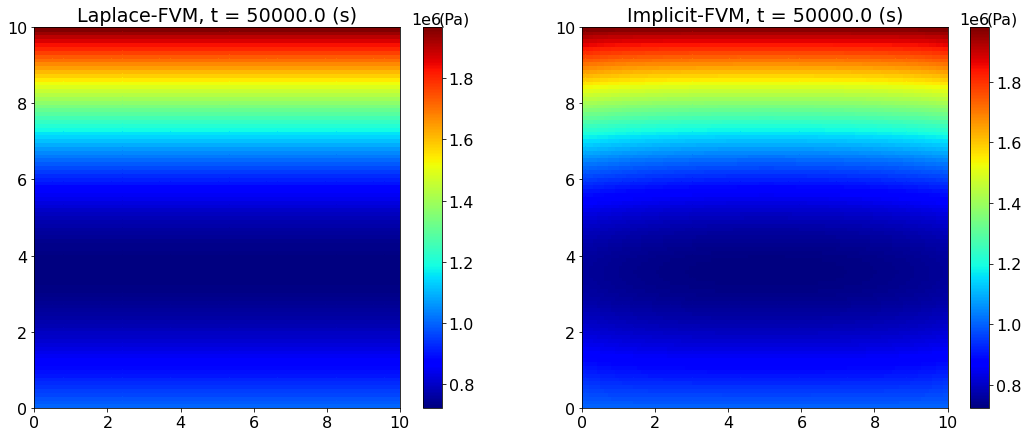

In [11]:
fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, list_p_Laplace[-1], cmap = 'jet')
plt.title('Laplace-FVM, t = '+str(list_t[-1])+' (s)')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)

plt.subplot(122)
plt.pcolor(x, y, list_p_implicit[-1], cmap = 'jet')
plt.title('Implicit-FVM, t = '+str(list_t[-1])+' (s)')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)
plt.show()

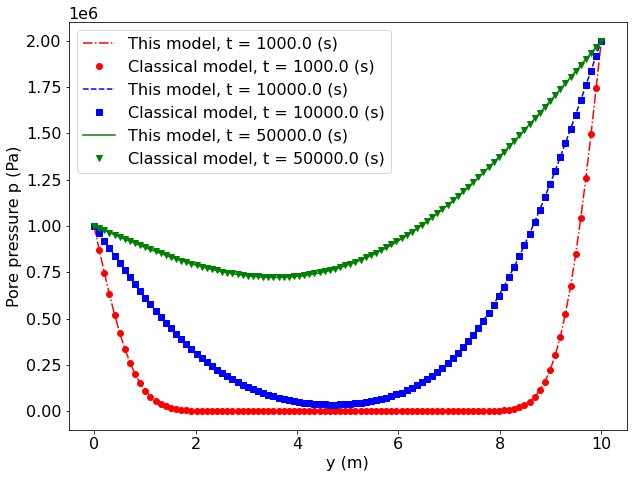

In [12]:
fig = plt.figure(figsize=[10.,7.5])
plt.subplot(111)

list_colors = ['r','b','g']
list_markers = ['o','s','v']
list_line_styles = ['-.', '--','-']

for idx in range(len(list_t)):
    p_LFVM = []
    p_IFVM = []
    y_coords = []

    for i in range(0, ny):
        p_LFVM.append(list_p_Laplace[idx][int(nx/2.)][i])
        p_IFVM.append(list_p_implicit[idx][int(nx/2.)][i])
        y_coords.append(y[int(nx/2.)][i])

    plt.plot(y_coords,p_LFVM,linestyle=list_line_styles[idx],color=list_colors[idx],label='This model, t = '+str(list_t[idx])+' (s)')
    plt.plot(y_coords,p_IFVM,list_markers[idx],color=list_colors[idx],label='Classical model, t = '+str(list_t[idx])+' (s)')
plt.xlabel('y (m)')
plt.ylabel('Pore pressure p (Pa)')
plt.legend()
plt.show()

### 1D diffusion for confirming that both method implemented are correct

There is a problem with single phase flow solver in GEOSX

# Forward Euler scheme
L = 10
Nx = 100
T = 1e4

Nt = 100
D = 1e-17/0.1/0.001/0.5e-9

x = np.linspace(0, L, Nx+1)   # mesh points in space
dx = x[1] - x[0]
list_t = np.linspace(0, T, Nt+1)    # mesh points in time
dt = list_t[1] - list_t[0]
F = D*dt/dx**2
u   = np.zeros(Nx+1)          # unknown u at new time level

# Data structures for the linear system
A = np.zeros((Nx+1, Nx+1))
for i in range(1, Nx):
    A[i,i-1] = -F
    A[i,i+1] = -F
    A[i,i] = (1 + 2*F)
A[0,0] = A[Nx,Nx] = 1

# Set initial condition
u[0] = pBot 
u[Nx] = pTop
for i in range(1, Nx):
    u[i] = 0

for n in range(0, Nt):
    # Solve linear system
    u = scipy.linalg.solve(A, u)

fig = plt.figure(figsize=[10.,7.5])
plt.subplot(111)
plt.plot(y_coords,p_LFVM,'k',label='Laplace-FVM')
plt.plot(y_coords,p_IFVM,'bo',label='Implicit-FVM')
plt.plot(x,u, 'r+', label='Forward Euler')
plt.xlabel('y (m)')
plt.ylabel('Pore pressure p (Pa)')
plt.legend()
#plt.title('t = ' + str(t) + ' (s)')
plt.show()
    

### Example 2: clone of example 1 with heterogeneous cxx, t = 2e4 (s)

In [13]:
pTop = 2e6
pBot = 1e6
Lx = 10.
Ly = 10.
nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

t = 2e4

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M

cxx = np.r_[c*np.ones( (int(nx/3),ny) ), 2*c*np.ones( (nx - 2*int(nx/3),ny) ), c*np.ones( (int(nx/3),ny) )]
cyy = cxx

p_Laplace = Laplace_FVM(x,y,nx,ny,cxx,cyy,t,4)
p_implicit = implicit_FVM(x,y,nx,ny,cxx,cyy,t,10)

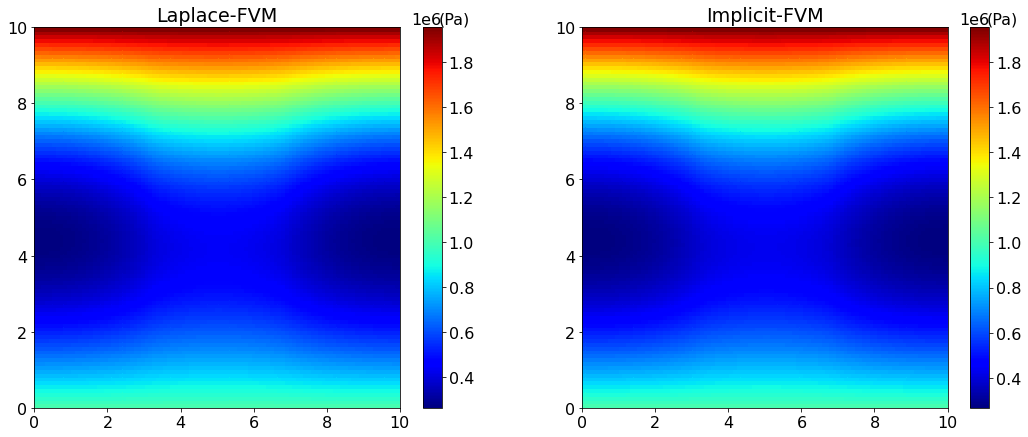

In [14]:
p_Laplace = p_Laplace.reshape(nx,ny)
p_implicit = p_implicit.reshape(nx,ny)

fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, p_Laplace, cmap = 'jet')
plt.title('Laplace-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)

plt.subplot(122)
plt.pcolor(x, y, p_implicit, cmap = 'jet')
plt.title('Implicit-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)
plt.show()

### Example 3: clone of example 2 with cxx random, t=1e5 (s)

In [15]:
pTop = 2e6
pBot = 1e6
Lx = 10.
Ly = 10.
nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

t = 1e5

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M

cxx = c*np.random.rand(nx,ny)
cyy = cxx

p_Laplace = Laplace_FVM(x,y,nx,ny,cxx,cyy,t,4)
p_implicit = implicit_FVM(x,y,nx,ny,cxx,cyy,t,10)

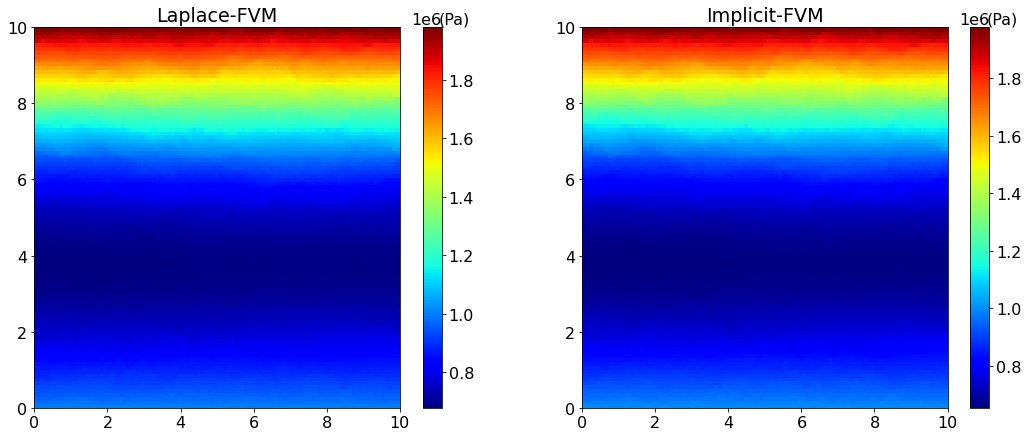

In [16]:
p_Laplace = p_Laplace.reshape(nx,ny)
p_implicit = p_implicit.reshape(nx,ny)

fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, p_Laplace, cmap = 'jet')
plt.title('Laplace-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)

plt.subplot(122)
plt.pcolor(x, y, p_implicit, cmap = 'jet')
plt.title('Implicit-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)
plt.show()

### Example 4: clone of example 3 with cyy = 10*cxx, t=1e5 (s)

In [17]:
pTop = 2e6
pBot = 1e6
Lx = 10.
Ly = 10.
nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

t = 1e5

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M

cxx = c*np.random.rand(nx,ny)
cyy = 10.*cxx

p_Laplace = Laplace_FVM(x,y,nx,ny,cxx,cyy,t,4)
p_implicit = implicit_FVM(x,y,nx,ny,cxx,cyy,t,10)

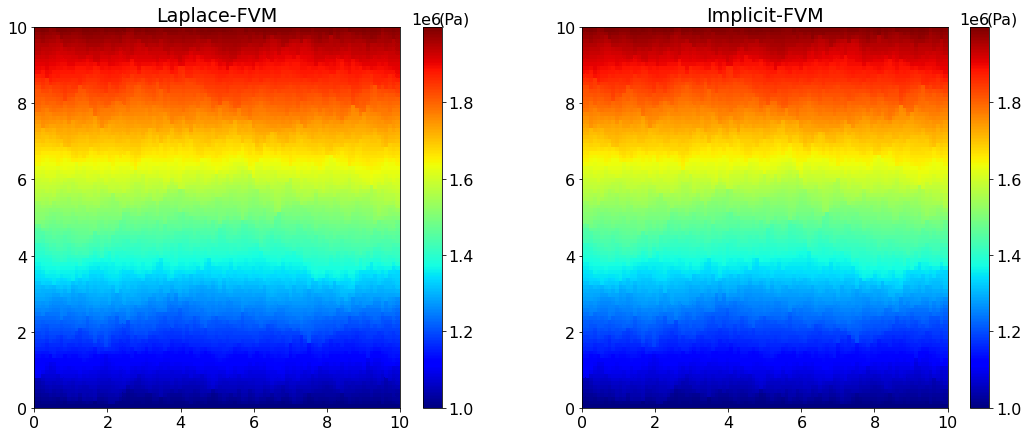

In [18]:
p_Laplace = p_Laplace.reshape(nx,ny)
p_implicit = p_implicit.reshape(nx,ny)

fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, p_Laplace, cmap = 'jet')
plt.title('Laplace-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)

plt.subplot(122)
plt.pcolor(x, y, p_implicit, cmap = 'jet')
plt.title('Implicit-FVM')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-20, y=1.04, rotation=0)
plt.show()